## **Elaborazione di Immagini Mediche**
### progetto: Brenciani - Filippi - Marini - Mengoni

indice:
1.   inizializzazione workspace
2.   creazione cartelle
3.   costruzione dataset e caricamento dati 
4.   pre-processing
5.   modello 
6.   validazione
7.   salvataggio maschere
8.   controllo dei dati

per il test set si è ipotizzato che sia disponibile con la stessa organizzazione del train e validation set. I codici sono quindi uguali ma separati per renderli più accessibili, per ovvi motivi i codici per il test set non sono stati testati. Vanno cambiati i percorsi (compreso quello per il caricamento del modello)

Inoltre dato che salvare le maschere nella dimensione originale riempiva completamente il nostro drive sono salvate sottocampionate, per salvarle in dimensione originale va tolto il commento alla riga corretta e commentata la riga con il sottocampionamento (parte 7 del codice)

# 1) inizializzazione workspace

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow==2.1.0
!pip install keras==2.3.1
!pip install segmentation_models==1.0.1
!pip install h5py==2.10.0 
!pip install plotly==5.3.1
!pip install imagecodecs


     |████████████████████████████████| 421.8 MB 26 kB/s 
     |████████████████████████████████| 50 kB 6.0 MB/s 
     |████████████████████████████████| 448 kB 39.2 MB/s 
     |████████████████████████████████| 3.8 MB 37.5 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=c87245d000944293a091928e8c0f9020f68c31e77943a9199a64c23c9b989b22
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Succes

In [3]:
import os
import random
import numpy as np
import plotly.express as px
import plotly.express as px

import matplotlib.pyplot as plt
from tqdm import tqdm
from skimage.io import imread, imshow, imsave
from skimage.transform import resize
from skimage.segmentation import mark_boundaries
import skimage 
from skimage import exposure
from scipy import ndimage
import scipy as sp
from keras.callbacks import ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model

from segmentation_models import Unet

from skimage.color import gray2rgb
from skimage.color import rgb2gray
import imagecodecs

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


# 2) creazione cartelle

In [ ]:
!pip install unrar
!unrar x "/content/drive/MyDrive/EIM laboratori/progetto/DATASET.zip" -d "/content/drive/MyDrive/EIM laboratori/progetto/DATASET"

In [ ]:
!unrar x "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/test.rar" #-d "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/test"
!unrar x "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/train.rar" #-d "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/train"
!unrar x "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/validation.rar"# -d "/content/drive/MyDrive/EIM laboratori/progetto/DATASET/validation"

a volte unrar dava problemi, che sono stati risolti utilizzando questa libreria come alternativa. Non siamo riusciti a individuarne la causa, abbiamo deciso di lasciare questo codice commentato nel caso si ripresentino

In [ ]:
# !pip install patool
# import patoolib
# patoolib.extract_archive("/content/drive/MyDrive/EIM laboratori/progetto/DATASET.zip" , outdir="/content/drive/MyDrive/EIM laboratori/progetto/" )

In [ ]:
# patoolib.extract_archive("/content/drive/MyDrive/EIM laboratori/progetto/DATASET/test.rar" , outdir="/content/drive/MyDrive/EIM laboratori/progetto/DATASET" )
# patoolib.extract_archive("/content/drive/MyDrive/EIM laboratori/progetto/DATASET/validation.rar" , outdir="/content/drive/MyDrive/EIM laboratori/progetto/DATASET" )
# patoolib.extract_archive("/content/drive/MyDrive/EIM laboratori/progetto/DATASET/train.rar" , outdir="/content/drive/MyDrive/EIM laboratori/progetto/DATASET" )

In [ ]:
# Creare la cartella che conterrà i risultati della rete nel test set
current_dir = '/content/drive/MyDrive/EIM laboratori/progetto'

path_results = os.path.join(current_dir ,"DATASET","test","automatic")
os.mkdir(path_results)
path_results = os.path.join(current_dir ,"DATASET","train","automatic")
os.mkdir(path_results)
path_results = os.path.join(current_dir ,"DATASET","validation","automatic")
os.mkdir(path_results)

#3) costruzione dataset e caricamento dati



### train e validation set

In [4]:
# carica la cartella
dataset_name = '/content/drive/MyDrive/EIM laboratori/progetto/DATASET'

# Path
TRAIN_IMG_path = os.path.join(dataset_name,'train','images')
TRAIN_MASK_path = os.path.join(dataset_name,'train','manual')
TRAIN_AUTO_path = os.path.join(dataset_name,'train','automatic')
TEST_IMG_path = os.path.join(dataset_name,'test','images')
TEST_AUTO_path = os.path.join(dataset_name,'test','automatic')
VAL_IMG_path = os.path.join(dataset_name,'validation','images')
VAL_MASK_path = os.path.join(dataset_name,'validation','manual')
VAL_AUTO_path = os.path.join(dataset_name,'validation','automatic')

# Estrazione della lista di volumi del training e validation set
train_images = os.listdir(TRAIN_IMG_path)
train_mask = os.listdir(TRAIN_MASK_path)
val_images = os.listdir(VAL_IMG_path)
val_mask = os.listdir(VAL_MASK_path)
test_images = os.listdir(TEST_IMG_path)

NUM_CLASSES = 3
# Inizializzazioni matrici
prop = 2040/1536

dim1 = 512
dim2 = round(dim1*prop)

a = np.zeros((2,100))


In [5]:
# TRAINING IMAGES
X_train = np.zeros((len(train_images),dim1,dim2,3), dtype=np.uint8)
size_train = np.zeros((len(train_images),2))

for n, id in tqdm(enumerate(train_images), total=len(train_images)):

    img = imread(TRAIN_IMG_path + '/' + id)
    size_train[n] = img.shape[0:1]
    img = resize(img,(dim1,dim2), preserve_range=True )
    X_train[n] = img
    
# TRAINING MASKS
Y_train = np.zeros((len(train_mask),dim1,dim2,3), dtype=np.float32)
N_cells_train = np.zeros(len(train_mask), dtype = np.uint8)

for n, id in tqdm(enumerate(train_mask), total=len(train_mask)):

    mask = imagecodecs.imread(TRAIN_MASK_path + '/' + id)
    image_shape = np.shape(mask)
    rows = image_shape[0]
    cols = image_shape[1] 
    try:
      N_cells_train[n] = image_shape[2] 
    except:
      N_cells_train[n] = 1

    mask_temp = np.zeros((rows, cols), dtype=np.uint8)
    mask_temp.shape
    for k in range(0,N_cells_train[n]):
      try:
        mask_layer = mask[:,:,k]
      except:
        mask_layer = np.zeros((rows, cols), dtype=np.uint8)
        
      mask_temp[mask_layer == 255] = 2
      mask_temp[mask_layer == 128] = 1
      mask_temp2 = resize(mask_temp,(dim1,dim2), preserve_range=True )

    mask_tempC = to_categorical(mask_temp2, num_classes=3, dtype='float32')
    Y_train[n,:,:,:] = mask_tempC

    del mask_temp, mask_temp2, mask_tempC

100%|██████████| 300/300 [04:54<00:00,  1.02it/s]


In [6]:
#VALIDATION IMAGES
X_val =  np.zeros((len(val_images),dim1,dim2,3), dtype=np.uint8)
size_val = np.zeros((len(val_images),2))

for n, id in tqdm(enumerate(val_images), total=len(val_images)):


    img = imread(VAL_IMG_path + '/' + id)
    size_val[n] = img.shape[0:1]
    img = resize(img,(dim1,dim2), preserve_range=True )
    X_val[n] = img

#VALIDATION MASKS
Y_val = np.zeros((len(val_mask),dim1,dim2,3), dtype=np.float32)
N_cells_val = np.zeros(len(val_mask), dtype = np.uint8)

for n, id in tqdm(enumerate(val_mask), total=len(val_mask)):

    mask = imagecodecs.imread(VAL_MASK_path + '/' + id)
    image_shape = np.shape(mask)
    rows = image_shape[0]
    cols = image_shape[1] 
    try:
      N_cells_val[n] = image_shape[2] 
    except:
      N_cells_val[n] = 1

    mask_temp = np.zeros((rows, cols), dtype=np.uint8)
    mask_temp.shape
    for k in range(0,N_cells_val[n]):
      try:
        mask_layer = mask[:,:,k]
      except:
        mask_layer = np.zeros((rows, cols), dtype=np.uint8)

      mask_temp[mask_layer == 255] = 2
      mask_temp[mask_layer == 128] = 1
      mask_temp2 = resize(mask_temp,(dim1,dim2), preserve_range=True )

    mask_tempC = to_categorical(mask_temp2, num_classes=3, dtype='float32')       
    Y_val[n,:,:,:] = mask_tempC

    del mask_temp, mask_temp2, mask_tempC



100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


In [7]:
del mask, img

 # 4) preprocessing

### train e validation set

In [8]:
fs = 256

def preprocessing(image):
  image = resize(image,(fs,fs), preserve_range = True)
  
  return image

In [9]:
X_train_processed = np.zeros((X_train.shape[0],fs,fs,3), dtype=np.uint8) 
Y_train_processed = np.zeros((X_train.shape[0],fs,fs,3), dtype=np.float32) 
for i in tqdm(range(X_train.shape[0])):

    image = X_train[i,:,:,:]
    l1 = preprocessing(image[:,:,0])
    l2 = preprocessing(image[:,:,1])
    l3 = preprocessing(image[:,:,2])
    X_train_processed[i,:,:,:] = np.stack((l1,l2,l3), axis=-1)

    mask = Y_train[i,:,:,:]
    m1 = preprocessing(mask[:,:,0])
    m2 = preprocessing(mask[:,:,1])
    m3 = preprocessing(mask[:,:,2])

    Y_train_processed[i,:,:,:] = np.stack((m1,m2,m3), axis=-1)  


X_val_processed = np.zeros((X_val.shape[0],fs,fs,3), dtype=np.uint8)
Y_val_processed = np.zeros((X_val.shape[0],fs,fs,3), dtype=np.float32)
#preprocessing validation
for i in tqdm(range(X_val.shape[0])):
    image = X_val[i,:,:,:]
    l1 = preprocessing(image[:,:,0])
    l2 = preprocessing(image[:,:,1])
    l3 = preprocessing(image[:,:,2])
    X_val_processed[i,:,:,:] = np.stack((l1,l2,l3), axis=-1)

    mask = Y_val[i,:,:,:]
    m1 = preprocessing(mask[:,:,0])
    m2 = preprocessing(mask[:,:,1])
    m3 = preprocessing(mask[:,:,2])

    Y_val_processed[i,:,:,:] = np.stack((m1,m2,m3), axis=-1)  

del l1,l2,l3,m1,m2,m3,mask,image

100%|██████████| 50/50 [00:04<00:00, 12.30it/s]


#5.1) definizione e allenamento modello
a scopo esemplificativo del processo di costruzione 

### creazione modello

[come funziona il data augmentation](https://www.analyticsvidhya.com/blog/2020/08/image-augmentation-on-the-fly-using-keras-imagedatagenerator/) -
[documentazione libreria PDF](https://readthedocs.org/projects/segmentation-models/downloads/pdf/latest/#page=11&zoom=100,96,478) -
[inizializzazione pesi](https://machinelearningmastery.com/weight-initialization-for-deep-learning-neural-networks/) -
[backbones](https://pypi.org/project/segmentation-models/0.1.2/)


In [ ]:
# Data augmentation (training set)
image_datagen = ImageDataGenerator(rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'reflect')

# Data augmentation (validation set)
val_datagen = ImageDataGenerator(rotation_range = 180,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   fill_mode = 'reflect')

seed = 1
def XYaugmentGenerator(X1, y, seed, batch_size):
    genX1 = image_datagen.flow(X1, y, batch_size=batch_size, seed=seed)
    genX2 = image_datagen.flow(y, X1, batch_size=batch_size, seed=seed)
    while True:
        X1i = genX1.next()
        X2i = genX2.next()
        yield X1i[0], X2i[0]

[activations](https://keras.io/api/layers/activations/)

[resnets](https://neurohive.io/en/popular-networks/resnet/)

[reset vs vgg](https://stats.stackexchange.com/questions/280179/why-is-resnet-faster-than-vgg)

In [ ]:
BACKBONE = 'inceptionv3'
model = Unet(backbone_name= BACKBONE,
            input_shape=(fs,fs,3),
            encoder_weights='imagenet', 
            encoder_freeze=True,
            decoder_block_type='upsampling',
            classes=3,
            activation='softmax')

model.compile('Adam', loss='binary_crossentropy', metrics=['binary_accuracy']) 

29089792/29084464 [==============================] - 0s 0us/step


### allenamento modello

[come scegliere l batch size](https://https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu)

[early stopping](https://https://en.wikipedia.org/wiki/Early_stopping)

[fine tuning](https://keras.io/guides/transfer_learning/)


[callbacks](https://keras.io/api/callbacks/)


[compile di keras](https://keras.io/api/models/model_training_apis/)

[early stoppung keras](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/)

[loss functions](https://keras.io/api/losses/probabilistic_losses/#kldivergence-class)


In [ ]:

# Parametri della rete
n_train_samples = X_train_processed.shape[0] 
n_val_samples = X_val_processed.shape[0] 
batch_size = 8 
n_epochs = 35

# Checkpoint definition
csv_logger = CSVLogger('.\log.out', append=True, separator=';')
callbacks_list = [csv_logger]


results = model.fit_generator(XYaugmentGenerator(X_train_processed,Y_train_processed,seed, batch_size), 
                              steps_per_epoch = np.ceil(float(len(X_train_processed))/float(batch_size)),
                              validation_data = val_datagen.flow(X_val_processed,Y_val_processed,batch_size), 
                              validation_steps = np.ceil(float(len(X_val_processed))/float(batch_size)),
                              shuffle = True,
                              epochs = n_epochs,
                              callbacks = callbacks_list) 


In [ ]:
#Salvataggio del modello allenato
#model.save('/content/drive/MyDrive/EIM laboratori/progetto/reti/5')


# 5.2) caricamento modello

In [21]:
model = load_model('/content/drive/MyDrive/EIM laboratori/progetto/rete')

# 6.1) funzioni per validazione


### funzioni per prestazioni

In [10]:
def IoU(im1, im2, empty_score=1.0):

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
         return empty_score

    union = np.logical_or(im1, im2)
    if union.sum() == 0:
        return empty_score

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / union.sum() )


In [11]:
def precision(im1, im2,empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()  
    if im_sum == 0:
         return empty_score

    im_sum2 = im2.sum()
    if im_sum2 == 0:
         return 0

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / im2.sum() )


In [12]:
def recall(im1, im2,empty_score=1.0):
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
         return empty_score
    im_sum2 = im1.sum()
    if im_sum2 == 0:
         return 0

    intersection = np.logical_and(im1, im2)

    return (intersection.sum() / im1.sum() )


In [13]:
def dice_coeff(im1, im2, empty_score=1.0): # dice o f1 score

    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    im_sum = im1.sum() + im2.sum()
    if im_sum == 0:
        return empty_score

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return (2. * intersection.sum() / im_sum)


### postprocessing e sovrapposizione

[opening and closing](https://www.geeksforgeeks.org/difference-between-opening-and-closing-in-digital-image-processing/)

[domcumentazione skimage](https://scikit-image.org/docs/stable/api/api.html)


In [14]:
def postprocessing(canale):
    # chiusura
    footprint = skimage.morphology.disk(3,dtype= bool)
    canale=sp.ndimage.binary_dilation(canale, footprint)
    footprint = skimage.morphology.disk(3,dtype= bool)
    canale=sp.ndimage.binary_erosion(canale, footprint)


    #rimozione piccoli oggetti
    from skimage import morphology
    canale = morphology.remove_small_objects(canale, min_size=80, connectivity= 1)
    canale = morphology.remove_small_holes(canale, area_threshold=80, connectivity=1)


    return canale

In [15]:
#gestione delle sovrapposizioni tra le maschere
def sovrapposizione(mask):

  #citoplasma e sfondo 
  l = 0 #livello da azzerare
  mask_sc = np.add(mask[:,:,0],mask[:,:,1])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l];
  mask_temp[indici] = 0;
  mask[:,:,l] = mask_temp; 

  #sfondo e nucleo 
  l = 0 #livello da azzerare
  mask_sc = np.add(mask[:,:,0],mask[:,:,2])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l];
  mask_temp[indici] = 0;
  mask[:,:,l] = mask_temp; 

  #citoplasma e nucleo 
  l = 1 #livello da azzerare
  mask_sc = np.add(mask[:,:,1],mask[:,:,2])
  indici = np.where(mask_sc == 2)

  mask_temp = mask[:,:,l]; 
  mask_temp[indici] = 0; 
  mask[:,:,l] = mask_temp; 

  # #mette come sfondo tutte le parti vuote (nere) e li sostituisce con lo sfondo 
  l = 0 #livello in questo con cui vengono riempiti i buchi
  mask_sc = mask[:,:,0]+mask[:,:,1]+mask[:,:,2]
  [indici1,indici2] = np.where(mask_sc == 0)
  
  mask_temp = np.zeros(mask[:,:,l].shape); #copia livello da modificare
  mask_temp[indici1,indici2] = 1; #assegna gli indici allo sfondo
  mask[:,:,l]=mask_temp + mask[:,:,l]
  return mask

### main funzione di validazione

In [16]:
def validazione(X,Y):

  from skimage import img_as_bool
  from skimage import img_as_float
  mask_auto_pv = np.zeros((X.shape[0],fs,fs,3), dtype = np.float32)
  IoUval = np.zeros((X.shape[0],4))
  Diceval = np.zeros((X.shape[0],4))
  Precisionval = np.zeros((X.shape[0],4))
  Recallval = np.zeros((X.shape[0],4))

  for n in range(X.shape[0]):
    image = X[n,:,:,:]
 
    img = np.reshape(image,(1,fs,fs,3))
    softmax = model.predict(img)
    softmax = np.reshape(softmax,(fs,fs,3))

    threshold1 = 0.5
    threshold2 = 0.1
    threshold3 = 0.2

    canale1 = softmax[:,:,0]
    canale2 = softmax[:,:,1]
    canale3 = softmax[:,:,2]

    canale1[canale1<=threshold1]=0
    canale1[canale1>threshold1]=1
    canale1=img_as_bool(canale1)
    canale1 = postprocessing(canale1)

    canale2[canale2<=threshold2]=0
    canale2[canale2>threshold2]=1
    canale2=img_as_bool(canale2)
    canale2 = postprocessing(canale2)

    canale3[canale3<=threshold3]=0
    canale3[canale3>threshold3]=1
    canale3=img_as_bool(canale3)
    canale3 = postprocessing(canale3)
    
    IoUval[n,0] = n
    Diceval[n,0] = n
    Precisionval[n,0] = n
    Recallval[n,0] = n

    mask_temp = img_as_float(np.stack((canale1,canale2,canale3), axis=-1)) 
    mask_temp = sovrapposizione(mask_temp)
 
    manual_mask = Y[n,:,:,:]

    IoUval[n,1] = IoU(manual_mask[:,:,1]+ manual_mask[:,:,2], mask_temp[:,:,1]+ mask_temp[:,:,2])*100 
    IoUval[n,2] = IoU(manual_mask[:,:,1], mask_temp[:,:,1])*100
    IoUval[n,3] = IoU(manual_mask[:,:,2], mask_temp[:,:,2])*100

    Diceval[n,1] = dice_coeff(manual_mask[:,:,1]+manual_mask[:,:,2], mask_temp[:,:,1]+mask_temp[:,:,2])*100
    Diceval[n,2] = dice_coeff(manual_mask[:,:,1], mask_temp[:,:,1])*100
    Diceval[n,3] = dice_coeff(manual_mask[:,:,2], mask_temp[:,:,2])*100

    Precisionval[n,1] = precision(manual_mask[:,:,1]+manual_mask[:,:,2], mask_temp[:,:,1]+mask_temp[:,:,2])*100
    Precisionval[n,2] = precision(manual_mask[:,:,1], mask_temp[:,:,1])*100
    Precisionval[n,3] = precision(manual_mask[:,:,2], mask_temp[:,:,2])*100
    
    Recallval[n,1] = recall(manual_mask[:,:,1]+manual_mask[:,:,2], mask_temp[:,:,1]+mask_temp[:,:,2])*100
    Recallval[n,2] = recall(manual_mask[:,:,1], mask_temp[:,:,1])*100
    Recallval[n,3] = recall(manual_mask[:,:,2], mask_temp[:,:,2])*100

    mask_auto_pv[n,:,:,:] = mask_temp

  IoUmean = np.mean(IoUval,0)
  IoUdev = np.std(IoUval,0)
  Dicemean = np.mean(Diceval,0)
  Dicedev = np.std(Diceval,0) 
  Precisionmean = np.mean(Precisionval,0)
  Precisiondev = np.std(Precisionval,0)
  Recallmean = np.mean(Recallval,0)
  Recalldev = np.std(Recallval,0)

  print(f"Valore IoU delle maschere :{IoUmean[1:4]} con deviazione standard: {IoUdev[1:4]}")
  print(f"Valore Dice delle maschere :{Dicemean[1:4]} con deviazione standard: {Dicedev[1:4]}")
  print(f"Valore Precision delle maschere :{Precisionmean[1:4]} con deviazione standard: {Precisiondev[1:4]}")
  print(f"Valore Recall delle maschere :{Recallmean[1:4]} con deviazione standard: {Recalldev[1:4]}")

  return mask_auto_pv,IoUval,IoUmean,IoUdev,Diceval,Dicemean,Dicedev,Precisionval,Precisionmean,Precisiondev,Recallval,Recallmean,Recalldev

### watershed


[watershed wikipedia](https://en.wikipedia.org/wiki/Watershed_(image_processing))

[watershed di skimage](https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_watershed.html)

[esempio interessante](
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_label.html#sphx-glr-auto-examples-segmentation-plot-label-py)

In [17]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
from skimage import measure, color, io
from skimage import img_as_ubyte,img_as_bool
from google.colab.patches import cv2_imshow

def watershed_function(mask_auto_pv,X, *k):
    try:
      k = k[0]
    except:
      k = 1
    k = k-1 # perchè gli indici partono da 0

    ncount=0
    markers_cells = np.zeros((X.shape[0],fs,fs))

    for n in range(X.shape[0]):

      img=mask_auto_pv[n,:,:,:] #maschera corrente
      cells=img[:,:,2]+img[:,:,1] #sommo maschera nuclei e citoplasmi

      img=img_as_ubyte(img)
      cells=img_as_ubyte(cells)
      kernel = np.ones((3,3),np.uint8)

      sure_bg = cv2.dilate(cells,kernel,iterations=2)
      
      dist_transform = cv2.distanceTransform(img[:,:,2],cv2.DIST_L2,5) # distance transform del nucleo
      ret2, sure_fg = cv2.threshold(dist_transform,0.5*dist_transform.max(),255,0)
      sure_fg = np.uint8(sure_fg)

      unknown = cv2.subtract(sure_bg,sure_fg)
      ret3, markers = cv2.connectedComponents(sure_fg)

      ncount = ncount + markers.max()+1
      markers = markers+10
      markers[unknown==255] = 0

      markers = cv2.watershed(img_as_ubyte(np.stack((cells,cells,cells),axis = -1)),markers)
      img[markers == -1] = [0,255,255]  

      img2 = color.label2rgb(markers, bg_label=0)

      markers_cells[n,:,:]=markers

      if n == k:
        fig = plt.figure(figsize=(40,20))
        ax0 = fig.add_subplot(1,8,4)
        ax0.imshow(sure_bg,cmap=plt.cm.gray), ax0.set_title('sure_bg')
        ax1 = fig.add_subplot(1,8,5)
        ax1.imshow(dist_transform,cmap=plt.cm.gray), ax1.set_title('dist_transform')
        ax2 = plt.subplot(1,8,6)
        ax2.imshow(sure_fg)
        ax2.set_title('sure_fg')
        ax3 = plt.subplot(1,8,7)
        ax3.imshow(unknown)
        ax3.set_title('unknown')

        ax0 = fig.add_subplot(1,8,3)
        ax0.imshow(cells,cmap=plt.cm.gray), ax0.set_title('cell mask')
        ax1 = fig.add_subplot(1,8,2)
        ax1.imshow(mask_auto_pv[n,:,:,:],cmap=plt.cm.gray), ax1.set_title(f"automatic mask number {k+1}")
        ax2 = plt.subplot(1,8,1)
        ax2.set_title('original image')
        ax2.imshow(X[n,:,:,:])
        ax3 = plt.subplot(1,8,8)
        ax3.imshow(img2)
        ax3.set_title('watershed segmentation')
    return markers_cells,ncount

### mask to greyscale e mask creation

funzioni per salvataggio maschere

In [18]:
def mask_to_grayscale(mask):

  mask_greyscale = np.zeros((fs,fs),dtype = np.uint8)
  mask_greyscale[mask[:,:,0] == 1] = 0
  mask_greyscale[mask[:,:,1] == 1] = 128
  mask_greyscale[mask[:,:,2] == 1] = 255

  return mask_greyscale

In [19]:
# mask cell sono le maschere con le cellule singole
# mask auto le maschere nromali 
def mask_creation(markers_cells,mask_auto_pv,X,*N_cells):
  try: 
    N_cells = N_cells[0]
  except:
    pass

  mask_cell_greyscale = [] 

  for n in range(0,X.shape[0]): 
    seq = np.array(range(10, int(np.max(markers_cells[n])+1))) #vettore classi (si parte da 10) es: seq=10 11 12 13 14 15 (6 segmentazioni)

    mask_cell=np.zeros((np.max(seq)-9,fs,fs)) # numero maschere cellule creato in base al numero di classi (1 canale, maschera binaria) [num=6=0..5] 
    #print(f"{mask_cell.shape[0]}:{np.max(seq)}")
    mask_cell_final=np.zeros((fs,fs,mask_cell.shape[0]-1), dtype = np.uint8)

    for i in range(1,mask_cell.shape[0]): # [1..5], escludo la prima maschera (0) che è lo sfondo!
        mask_cell_temp=np.zeros((fs,fs,3), dtype = np.uint8)
        k=seq[i]
        x,y=np.where(markers_cells[n]==k) #trova i punti appartenenti a quella classe(la prima è 11)
        mask_cell_temp[x,y,:]=mask_auto_pv[n,x,y,:]  # matrice globale contenente tutte le segmentazioni di tutte le cellule di tutto il train
        mask_cell_final[:,:,i-1] = mask_to_grayscale(mask_cell_temp)

    try:
      print(f"{n+1} : sono state trovate {mask_cell_final.shape[2]} cellule su {N_cells[n]}")
    except:
      print(f"{n+1} : sono state trovate {mask_cell_final.shape[2]} cellule")

    mask_cell_greyscale.append(mask_cell_final)

  return mask_cell_greyscale




# 6.2) validazione

In [22]:
print('TRAIN SET')
[mask_auto_train,IoUval_train, IoUmean_train,IoUdev_train,Diceval_train,Dicemean_train,Dicedev_train,Precisionval_train,Precisionmean_train,Precisiondev_train,Recallval_train,Recallmean_train,Recalldev_train]  = validazione(X_train_processed,Y_train_processed)
print('VAL SET')
[mask_auto_val, IoUval_val, IoUmean_val, IoUdev_val,Diceval_val,Dicemean_val,Dicedev_val,Precisionval_val,Precisionmean_val,Precisiondev_val,Recallval_val,Recallmean_val,Recalldev_val] = validazione(X_val_processed,Y_val_processed)   


TRAIN SET
Valore IoU delle maschere :[63.47800877 52.16252683 60.05463393] con deviazione standard: [25.28343906 21.1802832  25.24869207]
Valore Dice delle maschere :[73.6902349  65.2940513  70.86590033] con deviazione standard: [26.08454468 23.81765518 26.88770689]
Valore Precision delle maschere :[71.90355148 69.44204585 74.02046724] con deviazione standard: [26.85680521 27.04194623 29.16064529]
Valore Recall delle maschere :[77.47047182 63.07916815 69.79273004] con deviazione standard: [27.18890579 22.79996108 26.97358377]
VAL SET
Valore IoU delle maschere :[58.19490176 48.37140328 55.35512117] con deviazione standard: [26.95298499 22.19157625 25.92927471]
Valore Dice delle maschere :[68.7190365  61.32627451 66.73353141] con deviazione standard: [28.94591674 26.21212546 27.64971854]
Valore Precision delle maschere :[67.99307293 66.47589977 71.05946907] con deviazione standard: [30.89798012 31.07094691 30.67594724]
Valore Recall delle maschere :[72.74771824 59.35423776 66.34078837] c

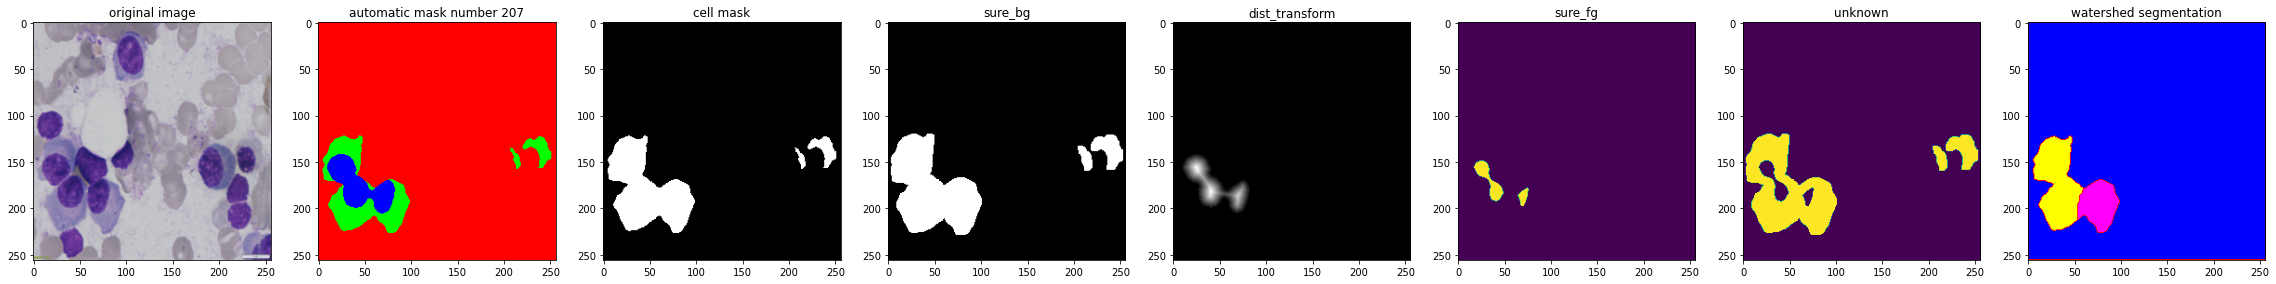

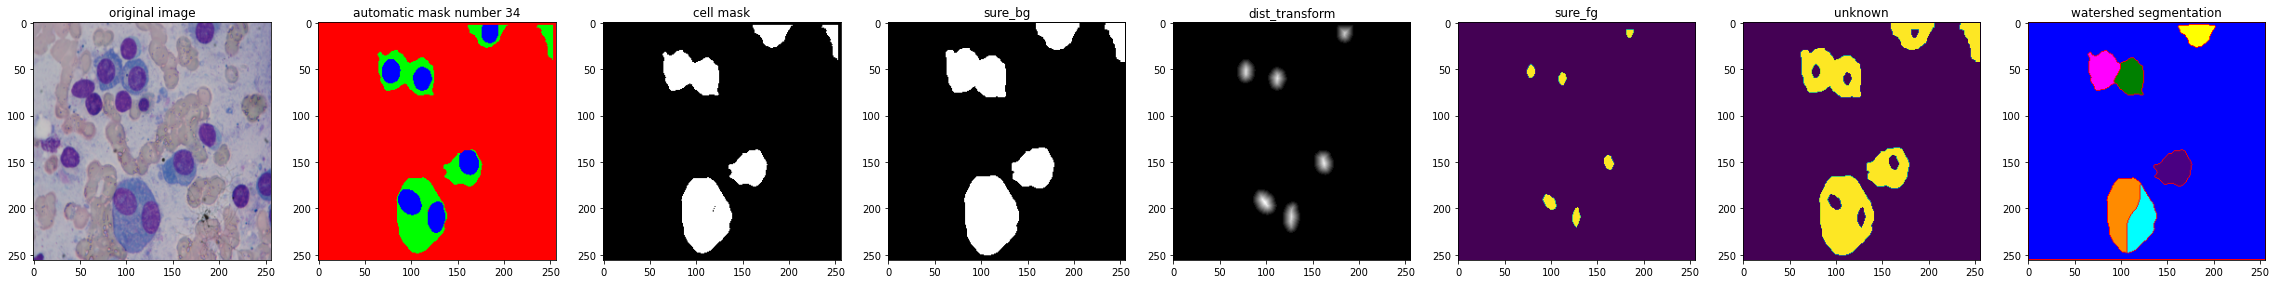

In [23]:
# dopo tutti gli input si puo inserire un parametro facoltativo per verificare l'applicazione del watershed su una cellula in particolare, default = 1 (la prima del dataset)
[markers_cells_train,ncount_train]  = watershed_function(mask_auto_train,X_train_processed,207)
[markers_cells_val,ncount_val]      = watershed_function(mask_auto_val,X_val_processed,34)

In [24]:
print('TRAIN SET')
mask_cell_greyscale_train = mask_creation(markers_cells_train,mask_auto_train,X_train_processed,N_cells_train)
print('VAL SET')
mask_cell_greyscale_val   = mask_creation(markers_cells_val,mask_auto_val,X_val_processed,N_cells_val)


TRAIN SET
1 : sono state trovate 7 cellule su 8
2 : sono state trovate 4 cellule su 4
3 : sono state trovate 5 cellule su 5
4 : sono state trovate 4 cellule su 4
5 : sono state trovate 6 cellule su 5
6 : sono state trovate 2 cellule su 2
7 : sono state trovate 5 cellule su 4
8 : sono state trovate 2 cellule su 3
9 : sono state trovate 10 cellule su 10
10 : sono state trovate 3 cellule su 3
11 : sono state trovate 8 cellule su 11
12 : sono state trovate 7 cellule su 6
13 : sono state trovate 4 cellule su 3
14 : sono state trovate 2 cellule su 1
15 : sono state trovate 6 cellule su 6
16 : sono state trovate 8 cellule su 6
17 : sono state trovate 3 cellule su 3
18 : sono state trovate 3 cellule su 2
19 : sono state trovate 7 cellule su 8
20 : sono state trovate 8 cellule su 8
21 : sono state trovate 10 cellule su 9
22 : sono state trovate 16 cellule su 14
23 : sono state trovate 9 cellule su 7
24 : sono state trovate 8 cellule su 8
25 : sono state trovate 10 cellule su 11
26 : sono state 

Controllo cellule

In [25]:
tot_cell_train = 0
tot_cell_val = 0

for mask in mask_cell_greyscale_train:
    tot_cell_train = tot_cell_train + mask.shape[2]

for mask in mask_cell_greyscale_val:
    tot_cell_val = tot_cell_val + mask.shape[2]

print(f"sono state trovate {tot_cell_train} su {np.sum(N_cells_train)} in totale nel train set")
print(f"sono state trovate {tot_cell_val} su {np.sum(N_cells_val)} in totale nel validation set")


sono state trovate 1812 su 1655 in totale nel train set
sono state trovate 243 su 224 in totale nel validation set


# 6.3) ridimensionamento maschere

#7) salvataggio maschere

In [ ]:

import tifffile
# TRAIN
for idx, cmask in enumerate(mask_cell_greyscale_train):
  id = train_images[idx]
  try:
    #cmask = resize(cmask, (int(dim1),int(dim2),cmask.shape[2]))
    cmask = resize(cmask, (int(size_train[idx,0]),int(size_train[idx,1]),cmask.shape[2]))
    tifffile.imsave(TRAIN_AUTO_path + '/' + id, cmask)
  except:
    #tifffile.imsave(TRAIN_AUTO_path + '/' + id, np.zeros((int(dim1),int(dim2),cmask.shape[2]), dtype = np.float32))
    tifffile.imsave(TRAIN_AUTO_path + '/' + id, np.zeros((int(size_train[idx,0]),int(size_train[idx,1]),cmask.shape[2]), dtype = np.float32))

#VALIDATION
for idx, cmask in enumerate(mask_cell_greyscale_val):

  id = val_images[idx]
  try:
    cmask = resize(cmask,(int(size_val[idx,0]),int(size_val[idx,1]),cmask.shape[2]))
    #cmask = resize(cmask, (int(dim1),int(dim2),cmask.shape[2]))
    tifffile.imsave(VAL_AUTO_path + '/' + id, cmask)
  except:
    #tifffile.imsave(VAL_AUTO_path + '/' + id, np.zeros((int(dim1),int(dim2),cmask.shape[2]), dtype = np.float32))
    tifffile.imsave(VAL_AUTO_path + '/' + id, np.zeros((int(size_train[idx,0]),int(size_train[idx,1]),cmask.shape[2]), dtype = np.float32))



/usr/local/lib/python3.7/dist-packages/skimage/transform/_warps.py:116: RuntimeWarning: invalid value encountered in true_divide
  np.asarray(output_shape, dtype=float))
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9418.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9449.tif'> writing zero size array to nonconformant TIFF
  UserWarning,
/usr/local/lib/python3.7/dist-packages/tifffile/tifffile.py:1655: UserWarning: <tifffile.TiffWriter '9653.tif'> writing zero size array to nonconformant TIFF
  UserWarning,


# 8) controllo dei dati

### **risultati caricamento immagini**

(<matplotlib.image.AxesImage at 0x7f1e1910e350>,
 Text(0.5, 1.0, 'manual mask validation'))

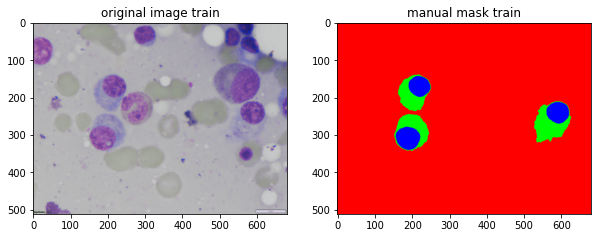

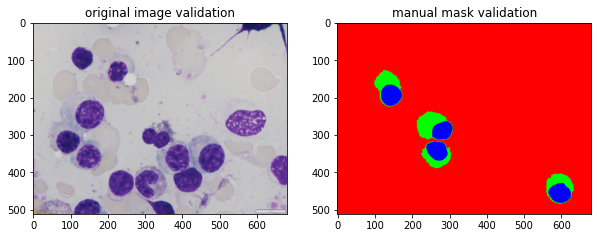

In [27]:
#TRAINING IMAGES
n = 10
train_i = X_train[n-1,:,:,:]
train_m = Y_train[n-1,:,:,:]

# Plot a video dell'immagine originale e della corrispondente segmentazione manuale
fig = plt.figure(figsize=(10,40))

ax = fig.add_subplot(1,2,1)
ax.imshow(train_i), ax.set_title('original image train')

ax = fig.add_subplot(1,2,2)
ax.imshow(train_m), ax.set_title('manual mask train')

#VALIDATION IMAGES
n = 19
val_i = X_val[n-1,:,:,:]
val_m = Y_val[n-1,:,:,:]

fig = plt.figure(figsize=(10,40))
ax = fig.add_subplot(1,2,1)
ax.imshow(val_i), ax.set_title('original image validation')

ax = fig.add_subplot(1,2,2)
ax.imshow(val_m), ax.set_title('manual mask validation')



### **risultati preprocessing**

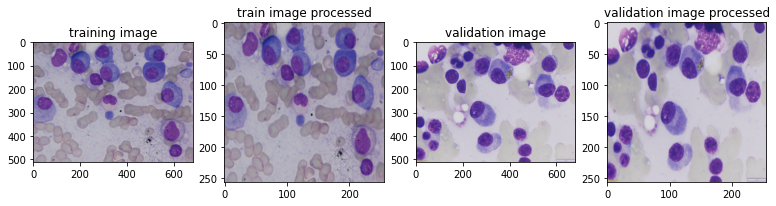

In [28]:
#risultati preprocessing
n = 1
train_p = X_train_processed[n-1,:,:]
train_i = X_train[n-1,:,:]

# Plot a video dell'immagine originale e della corrispondente segmentazione manuale
fig = plt.figure(figsize=(20,40))

ax1 = fig.add_subplot(1,6,1)
im1 = ax1.imshow(train_i,cmap=plt.cm.gray), ax1.set_title('training image')

ax2 = fig.add_subplot(1,6,2)
im2 = ax2.imshow(train_p,cmap=plt.cm.gray), ax2.set_title('train image processed')

n = 12
val_p = X_val_processed[n-1,:,:]
val_i = X_val[n-1,:,:]

ax1 = fig.add_subplot(1,6,3)
im1 = ax1.imshow(val_i,cmap=plt.cm.gray), ax1.set_title('validation image') 

ax1 = fig.add_subplot(1,6,4)
im1 = ax1.imshow(val_p,cmap=plt.cm.gray), ax1.set_title('validation image processed')      


### **visualizzazione delle maschere dopo il codice per la validazione e il post-processing**

Valore IoU della maschera 27 :[88.31750444 68.74798148 83.30269096]
Valore IoU della maschera 34 :[88.31750444 68.74798148 83.30269096]


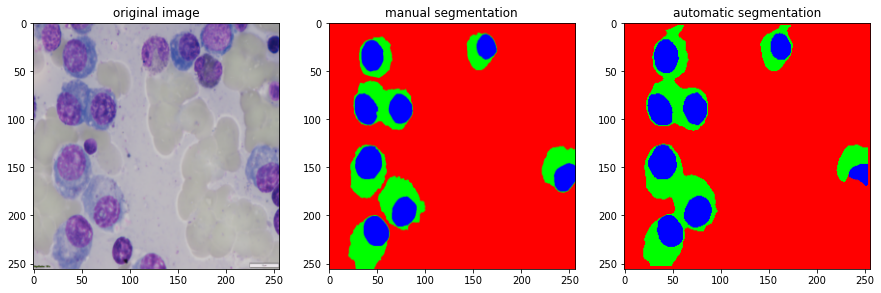

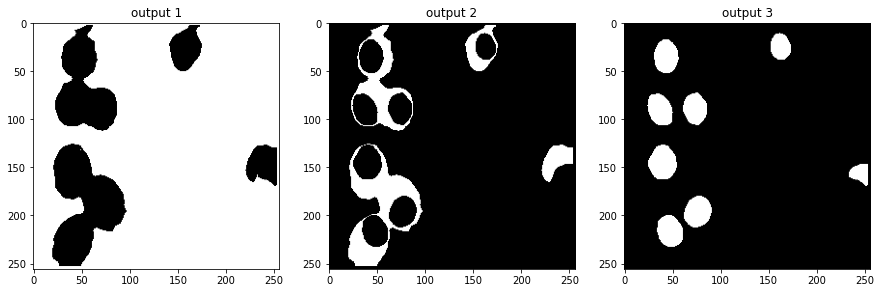

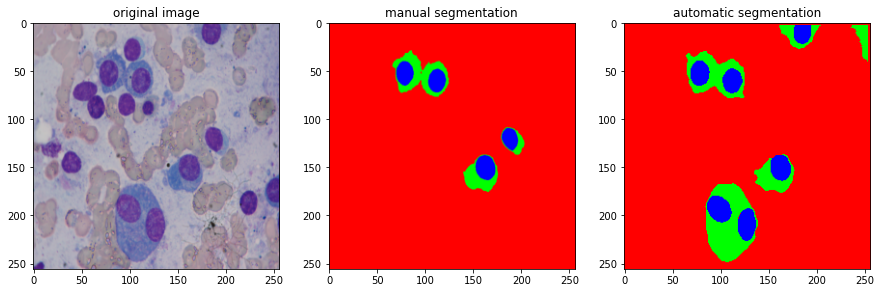

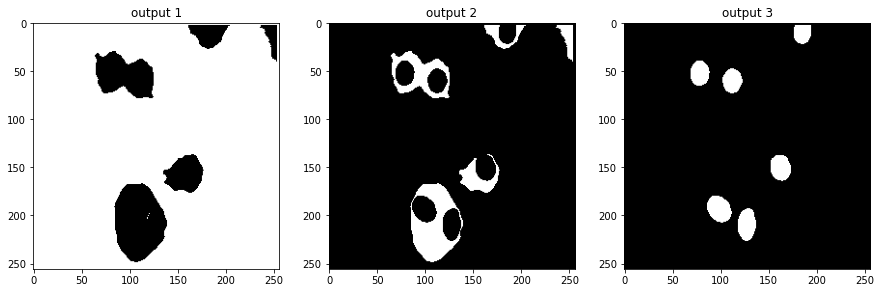

In [29]:
#Visualizzazione esempio TRAIN
n = 27
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,3,1)
ax1.imshow(X_train_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('original image')
ax2 = plt.subplot(1,3,2)
ax2.imshow(Y_train_processed[n-1,:,:,:],cmap=plt.cm.gray), ax2.set_title('manual segmentation')    
ax3 = plt.subplot(1,3,3)
ax3.imshow(mask_auto_train[n-1,:,:,:]), ax3.set_title('automatic segmentation')

mask_auto1 = mask_auto_train[n-1,:,:,0]
mask_auto2 = mask_auto_train[n-1,:,:,1]
mask_auto3 = mask_auto_train[n-1,:,:,2]

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(mask_auto1,cmap=plt.cm.gray), ax1.set_title('output 1')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(mask_auto2,cmap=plt.cm.gray), ax2.set_title('output 2')    
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(mask_auto3,cmap=plt.cm.gray), ax3.set_title('output 3') 
IoUmean = IoUval_train[n-1]
print(f"Valore IoU della maschera {n} :{IoUmean[1:4]}") 

# VALIDATION
n = 34

#Visualizzazione esempio validation
fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(1,3,1)
ax1.imshow(X_val_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('original image')
ax2 = plt.subplot(1,3,2)
ax2.imshow(Y_val_processed[n-1,:,:,:],cmap=plt.cm.gray), ax2.set_title('manual segmentation')    
ax3 = plt.subplot(1,3,3)
ax3.imshow(mask_auto_val[n-1,:,:,:]), ax3.set_title('automatic segmentation')

mask_auto1 = mask_auto_val[n-1,:,:,0]
mask_auto2 = mask_auto_val[n-1,:,:,1]
mask_auto3 = mask_auto_val[n-1,:,:,2]

fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(1,3,1)
ax1.imshow(mask_auto1,cmap=plt.cm.gray), ax1.set_title('output 1')
ax2 = fig.add_subplot(1,3,2)
ax2.imshow(mask_auto2,cmap=plt.cm.gray), ax2.set_title('output 2')    
ax3 = fig.add_subplot(1,3,3)
ax3.imshow(mask_auto3,cmap=plt.cm.gray), ax3.set_title('output 3') 
IoUmean_t = IoUval_val[n-1]
print(f"Valore IoU della maschera {n} :{IoUmean[1:4]}") 



###**visualizzazione risultato watershed**

Text(0.5, 1.0, 'watershed segmentation')

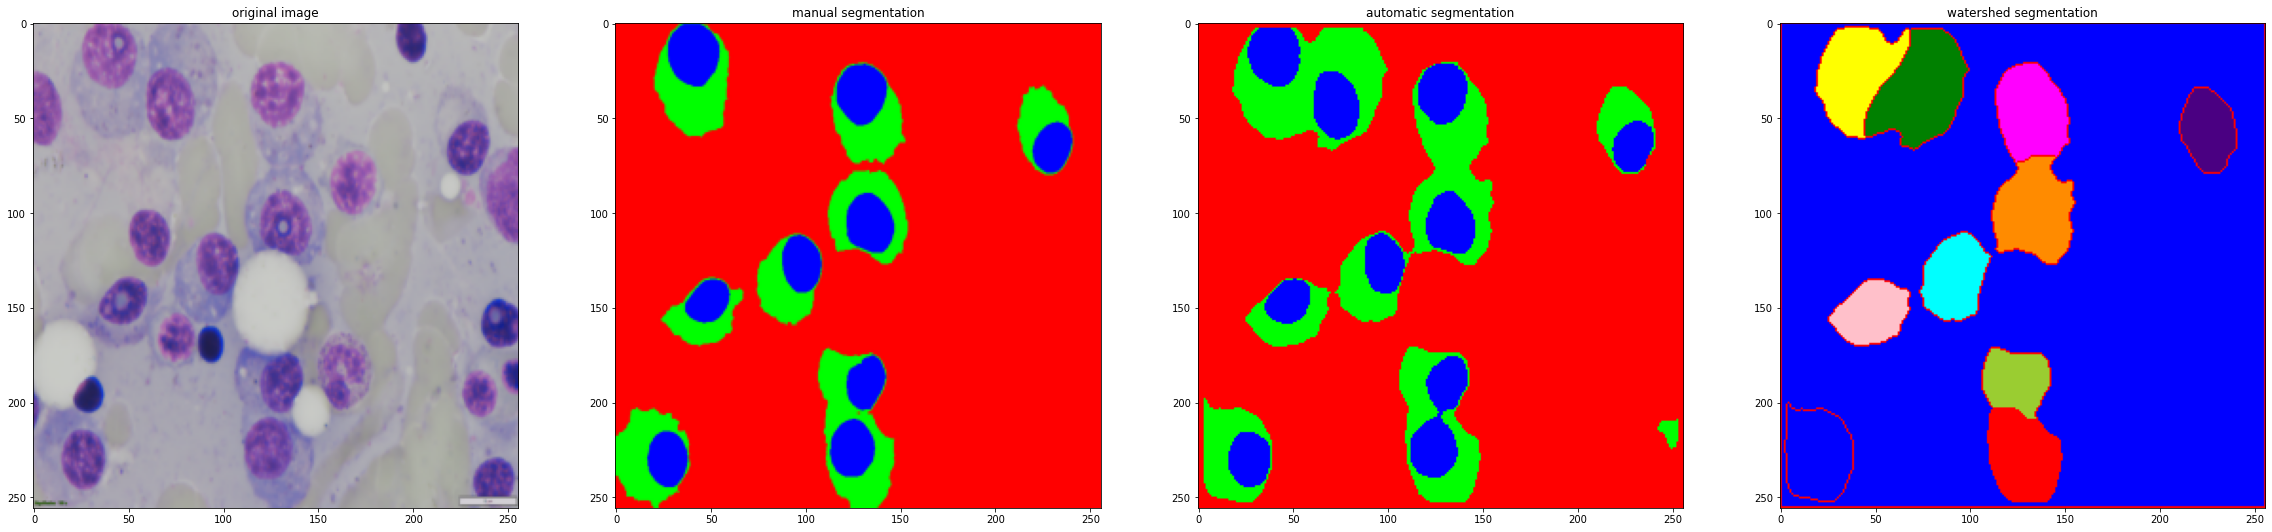

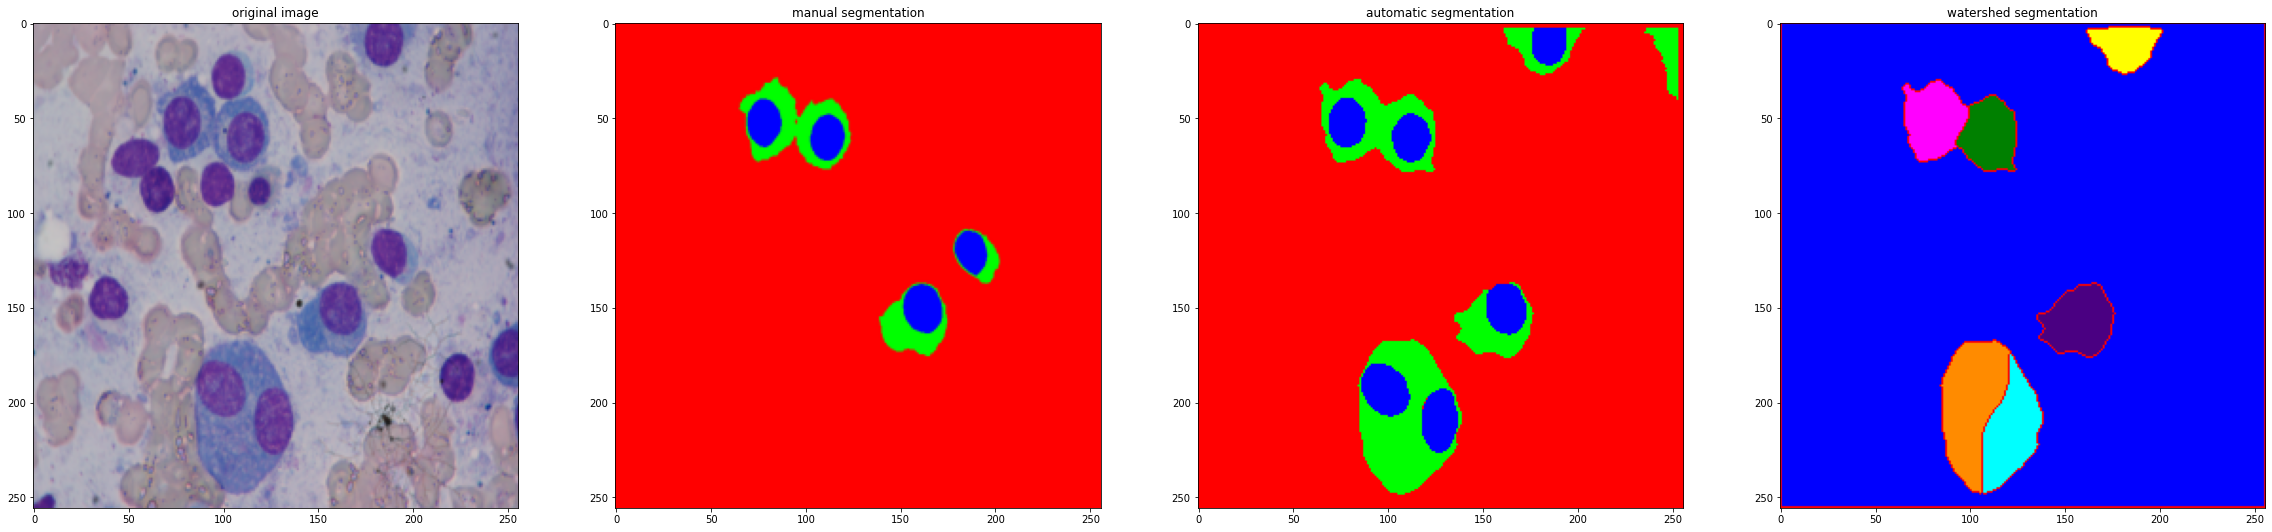

In [30]:
#TRAIN

n=21
fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(1,4,1)
ax0.imshow(X_train_processed[n-1,:,:,:],cmap=plt.cm.gray), ax0.set_title('original image')
ax1 = fig.add_subplot(1,4,2)
ax1.imshow(Y_train_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('manual segmentation')
ax2 = plt.subplot(1,4,3)
ax2.imshow(mask_auto_train[n-1,:,:,:],cmap=plt.cm.gray)
ax2.set_title('automatic segmentation')
ax3 = plt.subplot(1,4,4)
ax3.imshow(color.label2rgb(markers_cells_train, bg_label=0)[n-1,:,:],cmap=plt.cm.gray)
ax3.set_title('watershed segmentation')

#VALIDATION
n=34
fig = plt.figure(figsize=(40,20))
ax0 = fig.add_subplot(1,4,1)
ax0.imshow(X_val_processed[n-1,:,:,:],cmap=plt.cm.gray), ax0.set_title('original image')
ax1 = fig.add_subplot(1,4,2)
ax1.imshow(Y_val_processed[n-1,:,:,:],cmap=plt.cm.gray), ax1.set_title('manual segmentation')
ax2 = plt.subplot(1,4,3)
ax2.imshow(mask_auto_val[n-1,:,:,:],cmap=plt.cm.gray)
ax2.set_title('automatic segmentation')
ax3 = plt.subplot(1,4,4)
ax3.imshow(color.label2rgb(markers_cells_val, bg_label=0)[n-1,:,:],cmap=plt.cm.gray)
ax3.set_title('watershed segmentation')




### **esempio di output della funzione mask_to_grayscale e divisione cellule**

sono state trovate 8 cellule nell'immagine 27 del train set
sono state trovate 7 cellule nell'immagine 8 del validation set


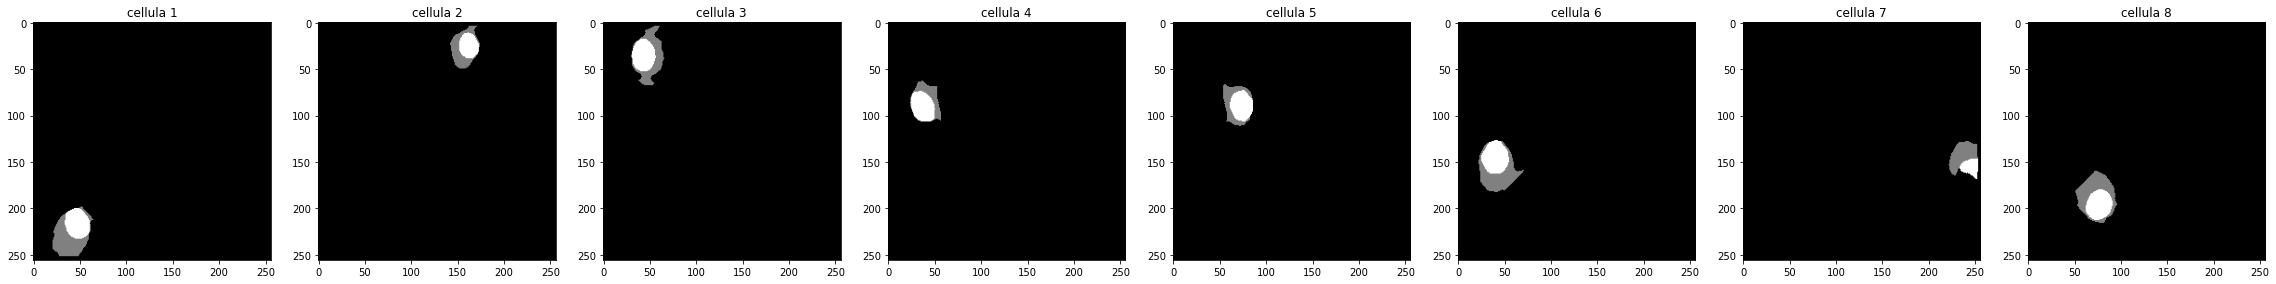

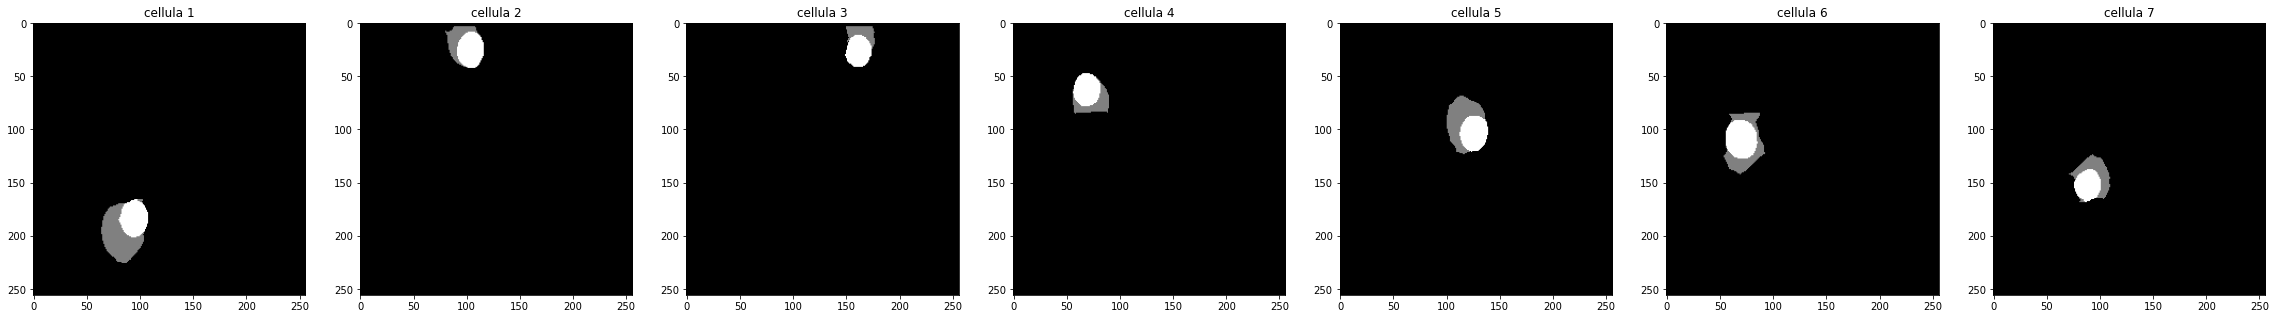

In [31]:
#TRAIN
n=27
mask_temp = mask_cell_greyscale_train[n-1]

fig = plt.figure(figsize=(40,20))

print(f"sono state trovate {mask_temp.shape[2]} cellule nell'immagine {n} del train set")
for i in range(mask_temp.shape[2]):
  ax = fig.add_subplot(1,mask_temp.shape[2],i+1)
  ax.imshow(mask_temp[:,:,i-1],cmap=plt.cm.gray), ax.set_title(f"cellula {i+1}")

#VALIDATION
n=8
mask_temp = mask_cell_greyscale_val[n-1]

fig = plt.figure(figsize=(40,20))

print(f"sono state trovate {mask_temp.shape[2]} cellule nell'immagine {n} del validation set")
for i in range(mask_temp.shape[2]):
  ax = fig.add_subplot(1,mask_temp.shape[2],i+1)
  ax.imshow(mask_temp[:,:,i-1],cmap=plt.cm.gray), ax.set_title(f"cellula {i+1}")



### **visualizzazione maschere originali e maschere create, singolarmente**

numero cellule trovate: 3
numero cellule effettive: 4


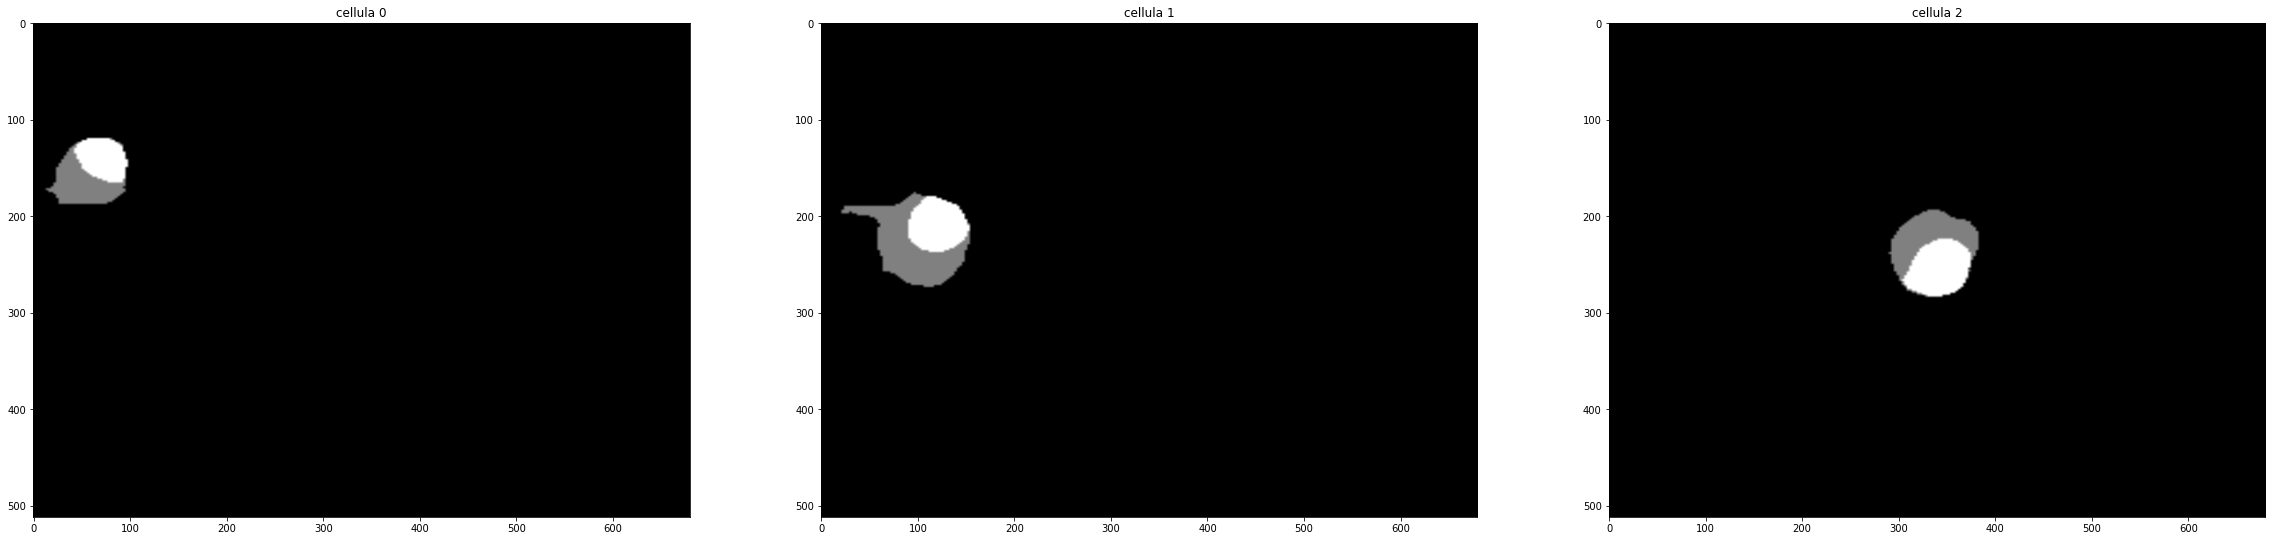

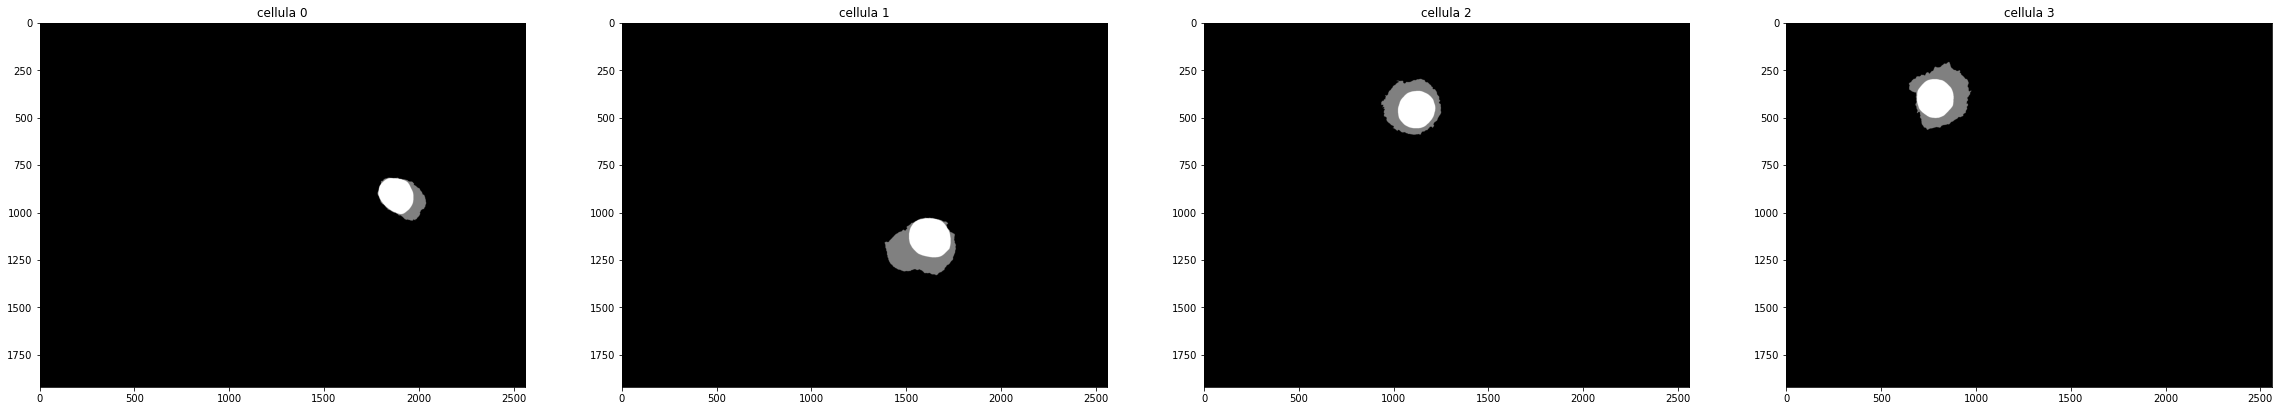

In [32]:
#img = mask_auto_val[n-1]
img = imread(VAL_AUTO_path + '/' + '115.tif')
print(f"numero cellule trovate: {img.shape[2]}")
fig1 = plt.figure(figsize=(40,20))

for i in range(img.shape[2]):
  ax = fig1.add_subplot(1,img.shape[2],i+1)
  ax.imshow(img[:,:,i],cmap=plt.cm.gray), ax.set_title(f"cellula {i}")

img = imread(VAL_MASK_path + '/' + '203.tif')
print(f"numero cellule effettive: {img.shape[2]}")

fig2 = plt.figure(figsize=(40,20))

for i in range(img.shape[2]):
  ax = fig2.add_subplot(1,img.shape[2],i+1)
  ax.imshow(img[:,:,i],cmap=plt.cm.gray), ax.set_title(f"cellula {i}")
del img
